In [33]:
import pandas as pd
import numpy as np
from core.helpers import yakeHelperFunctions as yhf
from sklearn.cluster import SpectralClustering
import itertools
from math import sqrt, floor
import os
import re
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
data_job = pd.read_csv("dataset/job.csv")

In [3]:
vectors = pd.read_csv("word2vec.model", delim_whitespace=True, skiprows=[0], header=None)


In [4]:
# set words as index rather than first column
vectors.index = vectors[0]
vectors.drop(0,axis=1, inplace=True)

In [5]:
data_job.shape

(8165, 1)

# make the sample of 15% of original data

In [6]:
samples_data = data_job.job.sample(frac=.15, random_state=45).astype(str)

# extract keywords & tokenize

In [7]:
keywords = yhf.keywords_yake(samples_data)
keywords_tokenized = yhf.tokenizing_after_yake(keywords)
keywords_set = [ set(job) for job in keywords_tokenized]

In [8]:
#remove empty sets
keywords_set_no_empty = [x for x in keywords_set if x]

# get word vectors  for keywords in jobs description

In [9]:
vectors.head()

,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
0,,,,,,,,,,,,,,,,,,,,,
de,-0.189453,0.181641,0.335938,-0.024048,-0.069824,0.075195,0.128906,-0.341797,-0.074707,-0.101074,...,0.000546,-0.017822,-0.060059,0.343750,-0.184570,0.112305,0.148438,0.116699,0.056885,0.105469
et,1.476465,0.650921,1.125034,-0.641027,2.133230,1.009610,0.522009,0.281066,-1.012411,1.352205,...,0.992428,0.372222,1.381234,-0.745683,0.519218,0.505964,-0.132756,0.549315,1.261921,0.157704
des,0.074707,0.112793,0.251953,-0.172852,-0.011658,0.233398,0.349609,-0.219727,-0.060059,0.287109,...,-0.023071,0.152344,0.111816,0.064453,-0.237305,0.000614,0.107422,0.141602,-0.036377,0.337891
la,2.521357,0.398546,0.327319,-0.384584,0.468277,0.268836,0.918718,1.271349,-2.448235,0.402296,...,1.211048,-0.172852,1.216892,1.828425,0.227053,0.490466,0.163657,0.464512,0.553507,1.263063
les,-0.120117,0.095703,0.168945,-0.030273,0.119141,0.147461,0.086426,-0.168945,0.051758,0.308594,...,0.182617,0.168945,-0.104492,0.033203,-0.488281,-0.053223,0.134766,-0.027832,0.087891,0.289062


In [10]:
def vectors_from_job(job):
        all_words = []
        for words in job:
                all_words.append(words)
        return vectors[vectors.index.isin(all_words)]

In [11]:
# test function for getting job description embedding (in the dumbest way possible)
def doc_embed_from_job(job):
        test_vectors = vectors_from_job(job)
        return test_vectors.mean()


In [12]:
# get document embeddings for job
num_of_jobs = len(keywords_set_no_empty)
doc_embeddings = np.zeros([num_of_jobs,300])
# TODO: handle jobs where all word out vocabulary
for i in range(num_of_jobs):
        embeddings =np.array(doc_embed_from_job(keywords_set_no_empty[i]))
        if np.isnan(embeddings).any():
                doc_embeddings[i,:] = np.zeros([1,300])
        else:
                doc_embeddings[i,:] = embeddings



In [13]:
doc_embeddings.shape

(1225, 300)

In [14]:
number_of_clusters = floor(sqrt(num_of_jobs))

# clustering

In [15]:
# k-means label assignment didn't work well
clustering = SpectralClustering(assign_labels='discretize', random_state=42, n_neighbors=number_of_clusters).fit(doc_embeddings)

In [16]:
pd.Series(clustering.labels_).value_counts()

0    980
2    203
3     16
6     12
7      6
5      4
4      2
1      2
dtype: int64

In [17]:
# explore our jobs by cluster number
jobs_subset = keywords_set_no_empty[0:num_of_jobs]
def get_keyword_set_by_cluster_number(number):
        cluster_index = list(clustering.labels_ == number)
        return list(itertools.compress(jobs_subset, cluster_index))

In [18]:
get_keyword_set_by_cluster_number(3)

[{'antenne',
  'antennes',
  'assurer',
  'dans',
  'des',
  'deutsche',
  'environnement',
  'finance',
  'finances',
  'foret',
  'für',
  'gesellschaft',
  'internationale',
  'l',
  'les',
  'pour',
  'projet',
  'responsable',
  'zusammenarbeit'},
 {'bon',
  'cameroun',
  'communautaire',
  'conseiller',
  'dans',
  'des',
  'description',
  'deutsche',
  'developpement',
  'economique',
  'endogene',
  'für',
  'gesellschaft',
  'giz',
  'gmbh',
  'innovations',
  'internationale',
  'le',
  'les',
  'numeriques',
  'pour',
  'projet',
  'promouvoir',
  'technique',
  'zusammenarbeit'},
 {'action',
  'agraire',
  'agraires',
  'appui',
  'coordination',
  'croix',
  'd',
  'dans',
  'des',
  'diagnostic',
  'diagnostics',
  'diplômés',
  'due',
  'est',
  'etude',
  'européenne',
  'financement',
  'française',
  'internationale',
  'jeunes',
  'l',
  'les',
  'par',
  'première',
  'pro',
  'projet',
  'rapport',
  'resilience',
  'rouge',
  'références',
  'régions',
  'union',

In [19]:
get_keyword_set_by_cluster_number(0)

[{'au',
  'communication',
  'conduire',
  'd',
  'dans',
  'des',
  'direction',
  'délivrées',
  'développer',
  'emploi',
  'est',
  'et',
  'expertise',
  'garant',
  'l',
  'les',
  'marketing',
  'mission',
  'mode',
  'normes',
  'offres',
  'place',
  'prestations',
  'principale',
  'projet',
  'promouvoir',
  'respect',
  'réseaux',
  'sein',
  'stockage',
  'votre',
  'wise'},
 {'appareils',
  'aptitudes',
  'assigné',
  'aux',
  'charge',
  'd',
  'différentes',
  'défectueuses',
  'esprit',
  'essences',
  'etre',
  'famille',
  'fois',
  'forte',
  'grumes',
  'les',
  'missions',
  'opérations',
  'ouverture',
  'pannes',
  'pièces',
  'principales',
  'qualifications',
  'requises',
  'réaliser',
  'sans',
  'sciées',
  'secondaires',
  'serez',
  'sur',
  'toutes',
  'tâches',
  'une',
  'vous'},
 {'concevoir',
  'convertir',
  'css',
  'des',
  'design',
  'designer',
  'documenter',
  'graphiques',
  'html',
  'maquettes',
  'nous',
  'pouvant',
  'professionnels',
 

In [20]:
get_keyword_set_by_cluster_number(2)

[{'a',
  'analysts',
  'breathe',
  'creative',
  'crystal',
  'digital',
  'engine',
  'forming',
  'group',
  'house',
  'marketing',
  'media',
  'optimization',
  'platforms',
  'ranging',
  'search',
  'social'},
 {'aids',
  'applications',
  'dans',
  'date',
  'des',
  'description',
  'données',
  'due',
  'elizabeth',
  'end',
  'foundation',
  'glaser',
  'job',
  'les',
  'number',
  'of',
  'pediatric',
  'positions',
  'programme',
  'reports',
  'start',
  'sud',
  'title'},
 {'accountability',
  'announcement',
  'assistance',
  'demonstrated',
  'experience',
  'gis',
  'highly',
  'integrated',
  'job',
  'manager',
  'managing',
  'mastery',
  'meal',
  'mechanism',
  'monitoring',
  'motivated',
  'of',
  'organization',
  'program',
  'project',
  'qualified',
  'services',
  'significant',
  'skills',
  'social',
  'system',
  'systems',
  'years'},
 {'aids',
  'announcement',
  'contract',
  'duration',
  'elizabeth',
  'foundation',
  'glaser',
  'hiv',
  'ict',


In [42]:
def get_job_infos_by_cluster_number(number,  data, cluster):
        return data[cluster.labels_ == number]

def remove_unnecessary_word(text, liste_word):
        text = text.lower()
        for element in liste_word:
                text = re.sub(element,"",text)
        return text

In [22]:
for i in range(num_of_jobs):
        print(f"cluster {i}:\n")
        print(get_job_infos_by_cluster_number(i, samples_data, clustering))
        print("\n")

cluster 0:

3725    OFFRE D'EMPLOI Au sein de la Direction Marketi...
7795    OPPORTUNITE POSITIONNEMENT ET MISSIONS DU POST...
7815    OPPORTUNITE: WEB DESIGNER Nous recherchons des...
4345    OFFRE D'EMPLOI TITRE DU POSTE: CHEF TECHNIQUE ...
4314    OFFRE D'EMPLOI QUI SOMMES NOUS ? Le Groupe CAD...
                              ...                        
132     Détails de l'annonce Poste proposé : Formateur...
4024    AVIS DE RECRUTEMENT Pour ses besoins de servic...
7435    OPPORTUNITE Nous recrutons pour notre imprimer...
6844    OFFRE D'EMPLOI: Responsable Commercial Descrip...
4348    OFFRE D'EMPLOI : Consultant fonctionnel ERP Ju...
Name: job, Length: 980, dtype: object


cluster 1:

2924    USAID Global Health Supply Chain-Procurement a...
6542    USAID Global Health Supply Chain-Procurement a...
Name: job, dtype: object


cluster 2:

1930    Paid Internship – Social Media Marketing & Sea...
1966    Elizabeth Glaser Pediatric AIDS Foundation (EG...
4594    JOB ANNOUNCEMENT A 

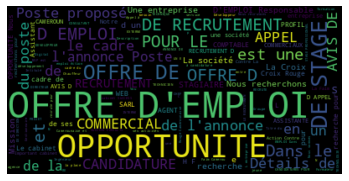

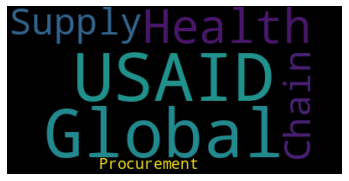

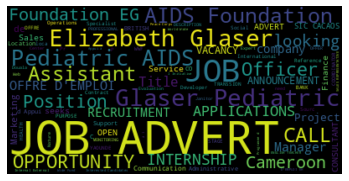

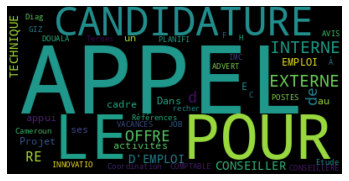

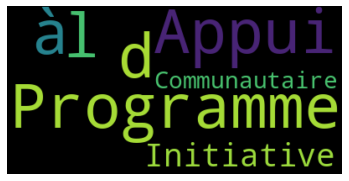

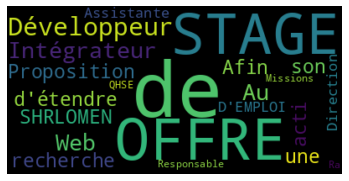

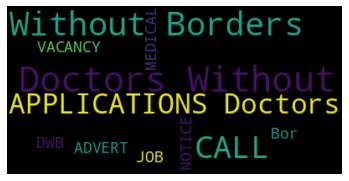

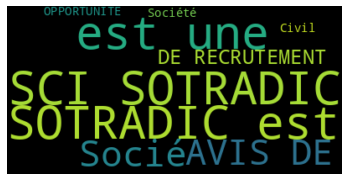

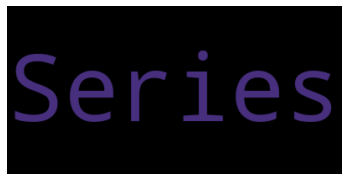

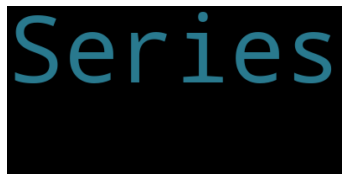

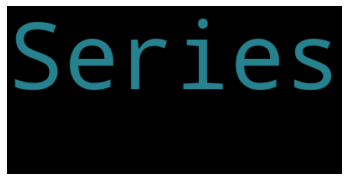

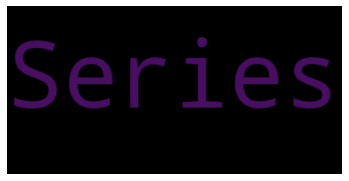

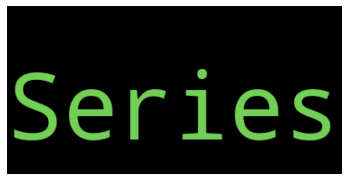

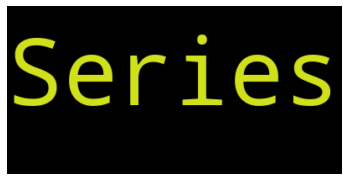

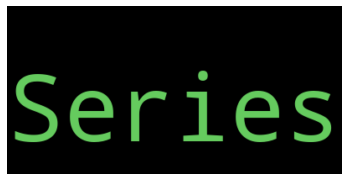

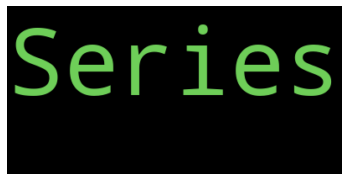

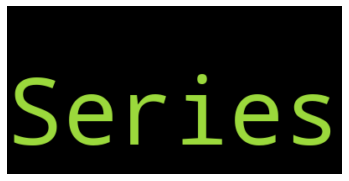

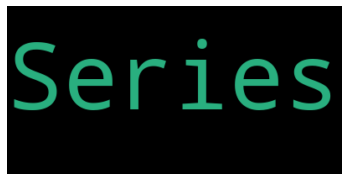

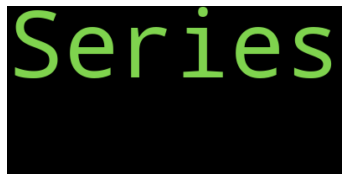

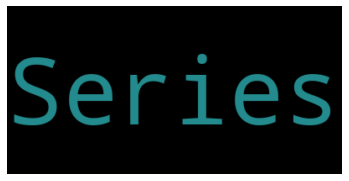

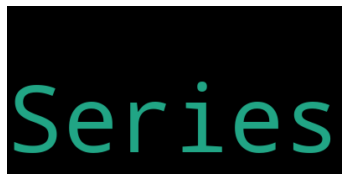

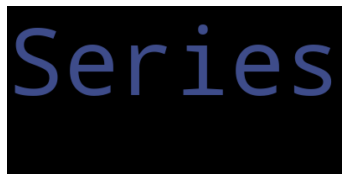

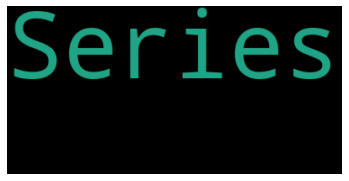

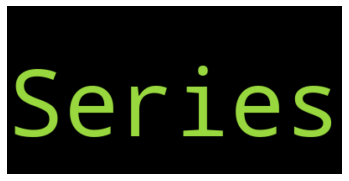

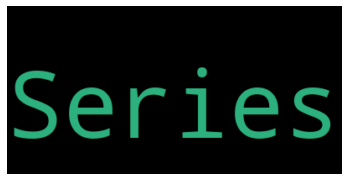

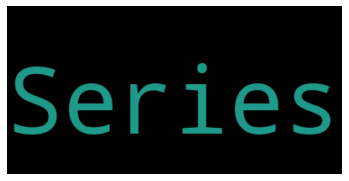

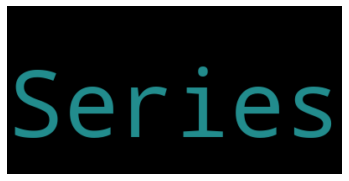

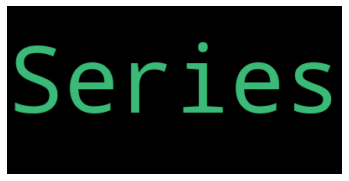

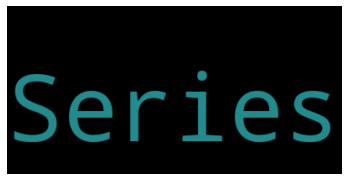

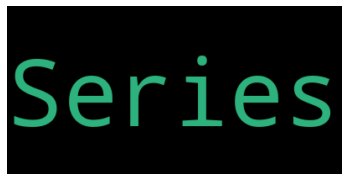

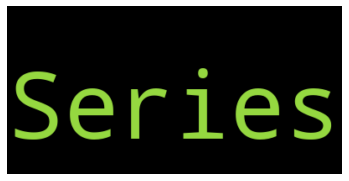

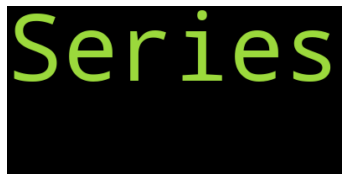

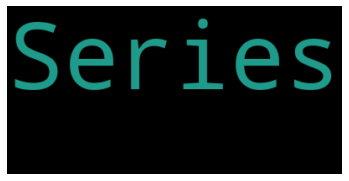

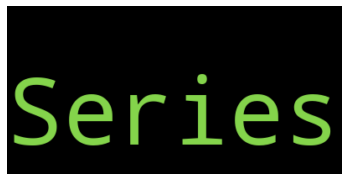

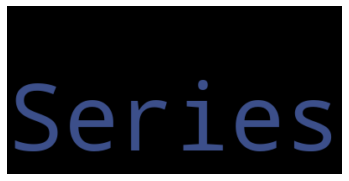

In [41]:

for i in range(number_of_clusters):
        jobs_as_string = get_job_infos_by_cluster_number(i, samples_data, clustering)\
        .to_string(index=True)
        jobs_as_string = remove_unnecessary_word(jobs_as_string,[])
        # Generate a word cloud image
        wordcloud = WordCloud().generate(jobs_as_string)

        # Display the generated image:
        # the matplotlib way:

        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()

# refining clustering
1. drop empty clusters
2. identified large cluster
3. recluster those cluster

In [23]:
cluster_counts = pd.Series(clustering.labels_).value_counts()
max_cluster_size = number_of_clusters * 2
big_clusters = cluster_counts[cluster_counts > max_cluster_size]

In [24]:
big_clusters

0    980
2    203
dtype: int64

In [25]:
# first
cluster_label = big_clusters.index[0]
sub_sample = samples_data[clustering.labels_ == cluster_label]
sub_cluster_embeddings = doc_embeddings[clustering.labels_ == cluster_label]

In [26]:
number_of_sub_clusters = floor(sqrt(sub_sample.shape[0]))

In [27]:
sub_clustering = SpectralClustering(assign_labels='discretize', random_state=42, n_neighbors=number_of_sub_clusters, n_clusters=number_of_sub_clusters).fit(sub_cluster_embeddings)

In [28]:
for i in range(number_of_sub_clusters):
        print(f"cluster {i}:\n")
        print(get_job_infos_by_cluster_number(i, sub_sample, sub_clustering))
        print("\n")


cluster 0:

7795    OPPORTUNITE POSITIONNEMENT ET MISSIONS DU POST...
7815    OPPORTUNITE: WEB DESIGNER Nous recherchons des...
4345    OFFRE D'EMPLOI TITRE DU POSTE: CHEF TECHNIQUE ...
4314    OFFRE D'EMPLOI QUI SOMMES NOUS ? Le Groupe CAD...
5842    OFFRE D'EMPLOI: CUISINIER Pour besoin de ses s...
                              ...                        
6262    AVIS DE RECRUTEMENT Titre du poste: Médecin gé...
4024    AVIS DE RECRUTEMENT Pour ses besoins de servic...
7435    OPPORTUNITE Nous recrutons pour notre imprimer...
6844    OFFRE D'EMPLOI: Responsable Commercial Descrip...
4348    OFFRE D'EMPLOI : Consultant fonctionnel ERP Ju...
Name: job, Length: 721, dtype: object


cluster 1:

6423    OFFRE D'EMPLOI Organisation importante, neutre...
1600    Offre d’emploi Action Contre La Faim – Camerou...
6404    Offre d’emploi Action Contre La Faim – Camerou...
2674    Offre d’emploi Action Contre La Faim – Camerou...
4178    Offre d’emploi Action Contre La Faim – Camerou...
4046    

In [29]:
 pd.Series(sub_clustering.labels_).value_counts()

0     721
3      39
26     16
25     16
1      15
22     14
6      14
23     11
7      11
4      10
8      10
20     10
14      9
28      9
19      8
24      7
10      7
16      7
9       6
17      6
11      5
21      4
18      4
27      3
13      3
5       3
29      3
30      3
15      2
2       2
12      2
dtype: int64

# Word clouds

In [30]:
get_job_infos_by_cluster_number(4, sub_sample, sub_clustering)

2008    INFORMATIONS SUR LE POSTE Intitulé du poste Sa...
3711    The International Rescue Committee Cameroon (I...
5613    L’International Rescue Committee Cameroon (IRC...
6571    L’International Rescue Committee Cameroon (IRC...
7210    DESCRIPTION DE L'EMPLOI Profession: Spécialist...
5800    OFFRE D’EMPLOI: ASSISTANT WASH L’International...
4324    DESCRIPTION DE L'EMPLOI Position: Senior Proje...
4669    L’International Rescue Committee Cameroon (IRC...
1884    OFFRE D'EMPLOI: CHAUFFEUR L’International Resc...
7302    OFFRE D'EMPLOI Poste :  Responsable Communicat...
Name: job, dtype: object

In [35]:
jobs_from_cluster = get_job_infos_by_cluster_number(4, sub_sample, sub_clustering)
jobs_as_string = jobs_from_cluster.to_string(index=True)

(-0.5, 399.5, 199.5, -0.5)

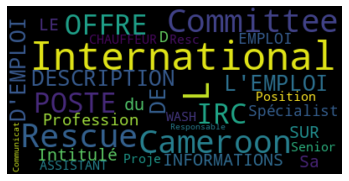

In [38]:
wordcloud = WordCloud().generate(jobs_as_string)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")


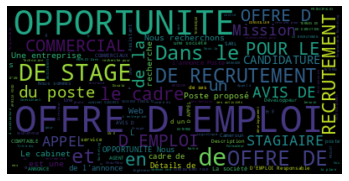

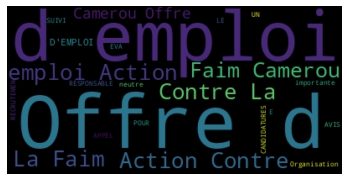

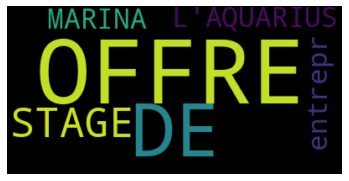

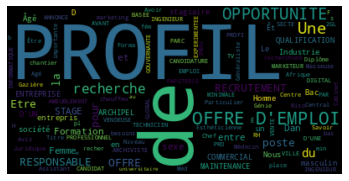

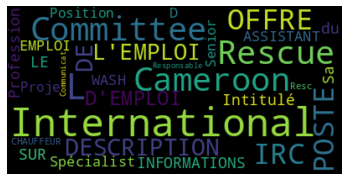

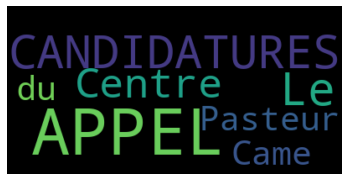

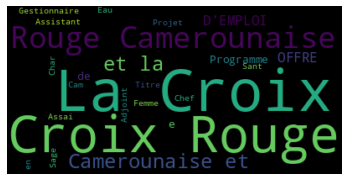

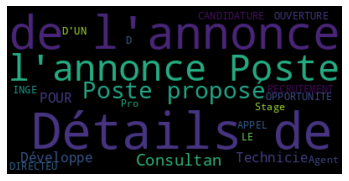

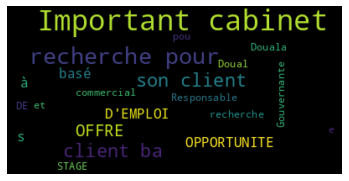

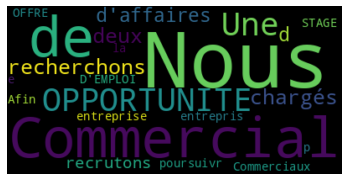

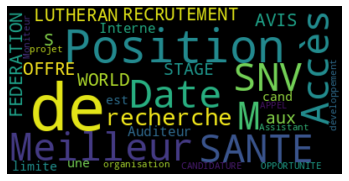

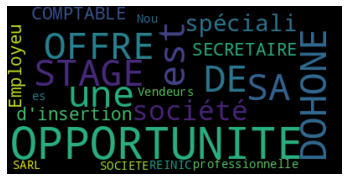

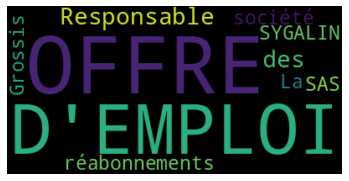

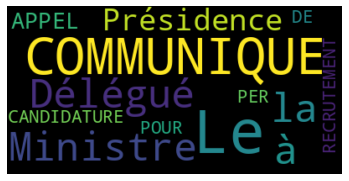

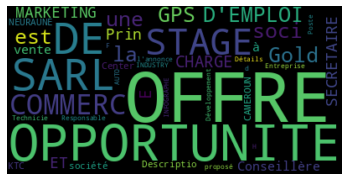

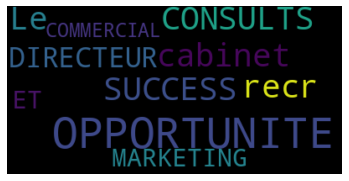

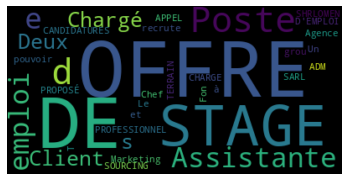

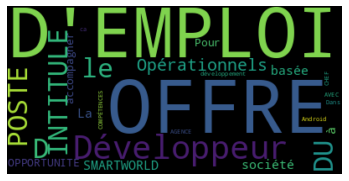

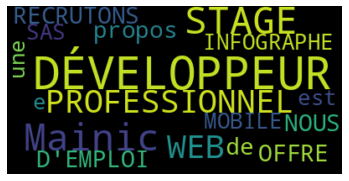

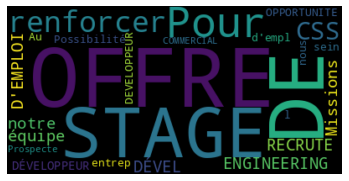

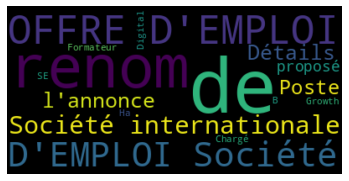

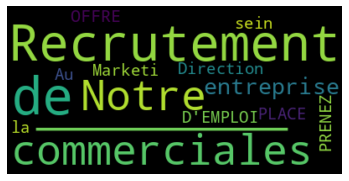

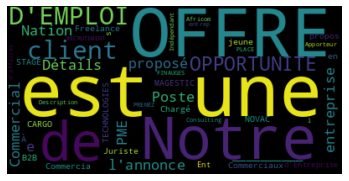

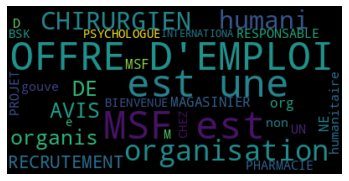

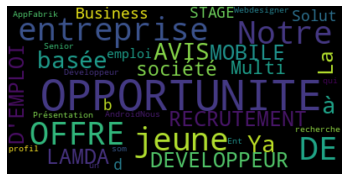

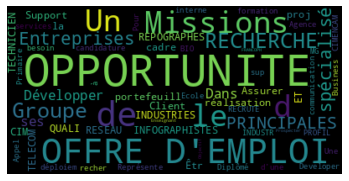

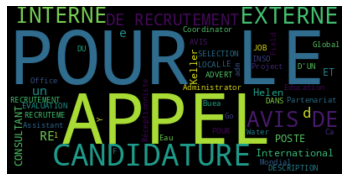

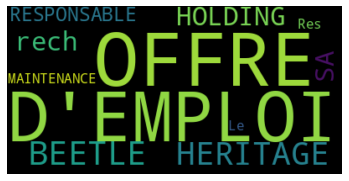

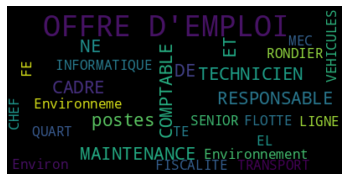

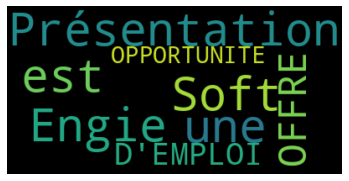

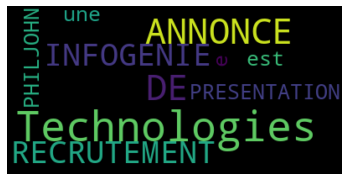

In [40]:


for i in range(number_of_sub_clusters):
        jobs_as_string = get_job_infos_by_cluster_number(i, sub_sample, sub_clustering)\
        .to_string(index=True)
        # Generate a word cloud image
        wordcloud = WordCloud().generate(jobs_as_string)

        # Display the generated image:
        # the matplotlib way:

        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()

